In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\Alisa\anaconda3\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


Источник датасета https://www.kaggle.com/datasets/adammaus/predicting-churn-for-bank-customers
Данные об оттоке клиентов банка. Необходимо подобрать лучшую модель для **предсказания оттока клиентов банка** и сделать **оценку экономической эффективности** использования модели

In [55]:
df = pd.read_csv('/Users/Alisa/Downloads/churn_data.csv')
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [56]:
df['Exited'].value_counts() # проверим соотношение классов

0    7963
1    2037
Name: Exited, dtype: int64

In [57]:
df.duplicated().sum() # проверим дубли

0

Исправим дисбаланс классов

In [6]:
df_0 = df.loc[df['Exited'] == 0]
df_0 = df_0.sample(2037)
df_1 = df.loc[df['Exited'] == 1]

In [7]:
frames = [df_0, df_1]
df = pd.concat(frames)
df = df.sample(frac = 1, random_state = 1)

Делим на train, test и val-выборки

In [8]:
X = df.drop(columns=['Exited'])
y = df['Exited']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.7, random_state = 0)

In [10]:
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size = 0.7, random_state = 0)

Собираем Pipeline для обработки таблицы признаков: признаки у нас категориальные и количественные (непрерывные). Категориальные переменные будем кодировать OneHotEncoder (в виде разреженной матрицы 0 и 1)

In [11]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    

class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [12]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [13]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    
    final_transformers.append((cont_col, cont_transformer))

In [14]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [15]:
models_results = {
    'model_type': [],
    'threshold': [],
    'f_score': [],
    'precision': [],
    'recall': [],
}

Осуществим предсказание разными моделями CatBoost, XGBoost, GBM, также для сравнения используем логистическую регрессию (для нее мы приведем признаки к единому масштабу в отдельном пайплайне). Для лучшей модели сделаем матрицу ошибок. 

**1. CatBoostclassifier**

In [16]:
from catboost import CatBoostClassifier

In [17]:
catboost_pipeline = Pipeline([
    ('features', feats),
    ('catboost_classifier', CatBoostClassifier(iterations=25, random_state=42)),
])

In [18]:
catboost_pipeline.fit(X_train, y_train)

Learning rate set to 0.474577
0:	learn: 0.5500665	total: 194ms	remaining: 4.65s
1:	learn: 0.4983378	total: 202ms	remaining: 2.32s
2:	learn: 0.4631219	total: 207ms	remaining: 1.52s
3:	learn: 0.4484002	total: 211ms	remaining: 1.11s
4:	learn: 0.4389280	total: 216ms	remaining: 864ms
5:	learn: 0.4273622	total: 220ms	remaining: 696ms
6:	learn: 0.4255246	total: 232ms	remaining: 597ms
7:	learn: 0.4150649	total: 236ms	remaining: 502ms
8:	learn: 0.4114798	total: 239ms	remaining: 425ms
9:	learn: 0.4072133	total: 242ms	remaining: 363ms
10:	learn: 0.4047788	total: 244ms	remaining: 311ms
11:	learn: 0.3945932	total: 247ms	remaining: 268ms
12:	learn: 0.3869886	total: 250ms	remaining: 231ms
13:	learn: 0.3795248	total: 253ms	remaining: 199ms
14:	learn: 0.3752661	total: 256ms	remaining: 171ms
15:	learn: 0.3700017	total: 259ms	remaining: 145ms
16:	learn: 0.3628289	total: 261ms	remaining: 123ms
17:	learn: 0.3583295	total: 264ms	remaining: 103ms
18:	learn: 0.3548957	total: 267ms	remaining: 84.4ms
19:	learn:

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [20]:
preds = catboost_pipeline.predict_proba(X_test)[:, 1]

In [21]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [22]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3881581061392072, F-Score=0.789, Precision=0.748, Recall=0.834


In [23]:
models_results['model_type'].append('CatBoost')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

**2. XGB**

In [24]:
pip install xgboost

  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.3
    Uninstalling numpy-1.24.3:
      Successfully uninstalled numpy-1.24.3
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Отказано в доступе: 'C:\\Users\\Alisa\\anaconda3\\Lib\\site-packages\\~-mpy\\.libs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [25]:
import xgboost as xgb

params = {
    'max_depth': 4,
    'eta': 0.01,
    'subsample': 0.4,
    'min_child_weight': 7,
    'n': 580,
}

In [26]:
xgb_pipeline = Pipeline([
    ('features', feats),
    ('xgboost_classifier', xgb.XGBClassifier(boosting_type='gbdt', **params)),
])

In [27]:
xgb_pipeline.fit(X_train, y_train)

[03:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "boosting_type", "n" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [29]:
preds = xgb_pipeline.predict_proba(X_test)[:, 1]

In [30]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4932951331138611, F-Score=0.782, Precision=0.800, Recall=0.765


In [31]:
models_results['model_type'].append('XGB')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

**3. GBM**

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

params_est = {
    'n_estimators': 300,
    'loss': 'exponential',
    'learning_rate': 0.08,
    'subsample': 0.691,
    'min_samples_leaf': 340,
    'random_state': 1,
}

In [33]:
gb_pipeline = Pipeline([
    ('features', feats),
    ('gb_boost_classifier', GradientBoostingClassifier(**params_est)),
])

In [34]:
gb_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [35]:
preds = gb_pipeline.predict_proba(X_test)[:, 1]

In [36]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4195298054272377, F-Score=0.762, Precision=0.727, Recall=0.802


In [37]:
models_results['model_type'].append('gbm')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

**4. Логистическая регрессия** Для нее добавим в пайплайн масштабирование данных при помощи StandardScaler

In [38]:
from sklearn.preprocessing import StandardScaler

In [39]:
final_transformers_sc = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    
    final_transformers_sc.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('scaler', StandardScaler())
            ])
    
    final_transformers_sc.append((cont_col, cont_transformer))

In [40]:
feats_sc = FeatureUnion(final_transformers_sc)

feature_processing_sc = Pipeline([('feats_sc', feats_sc)])

In [41]:
lr_pipeline = Pipeline([
    ('features', feats_sc),
    ('LogisticRegression', LogisticRegression(random_state=42)),
])

In [42]:
lr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [43]:
preds = lr_pipeline.predict_proba(X_test)[:, 1]

In [44]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [45]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [46]:
fscore = (2 * precision * recall) / (precision + recall)

In [47]:
ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.3667347063299205, F-Score=0.752, Precision=0.656, Recall=0.880


In [48]:
models_results['model_type'].append('LR')
models_results['threshold'].append(thresholds[ix])
models_results['f_score'].append(fscore[ix])
models_results['precision'].append(precision[ix])
models_results['recall'].append(recall[ix])

Сравниваем результаты

In [49]:
models_results = pd.DataFrame(models_results)
models_results

,model_type,threshold,f_score,precision,recall
0,CatBoost,0.388158,0.788671,0.747934,0.834101
1,XGB,0.493295,0.782097,0.800000,0.764977
2,gbm,0.419530,0.762322,0.726514,0.801843
3,LR,0.366735,0.751969,0.656357,0.880184


**Выбираем catboost**. Наверное, самая подходящая метрика здесь f_score (гармоническое среднее точности и полноты), но также важен recall (полнота), чтобы максимально охватить уходящих клиентов. Если учитывать оба параметра, CatBoost и логистическая регрессия показали лучшие результаты. 

In [50]:
preds = catboost_pipeline.predict_proba(X_val)[:, 1]

In [51]:
precision, recall, thresholds = precision_recall_curve(y_val, preds)

fscore = (2 * precision * recall) / (precision + recall)

ix = np.argmax(fscore)
print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')

Best Threshold=0.4044094324101164, F-Score=0.783, Precision=0.725, Recall=0.852


Для отобранной модели (на валидационной выборке) сделаем оценку экономической эффективности:
По условиям задания удержание клиента стоит 1 доллар, прибыль в случае удержания правильно определенного "уходящего" клиента 2 доллара

Построим матрицу ошибок

In [52]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[134  57]
 [ 27 149]]


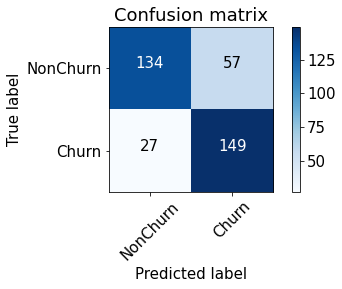

In [53]:
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_val, preds>thresholds[ix])
plt.figure(figsize=(6, 4))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Стоимость удержания клиентов: retain_sum
Прибыль при удержании "уходящих": income

In [54]:
TN = cnf_matrix[0][0]
FP = cnf_matrix[0][1]
FN = cnf_matrix[1][0]
TP = cnf_matrix[1][1]


retain_sum = (FP + TP) * 1
income = TP * 2

income - retain_sum

92

Таким образом, использования модели в данном случае принесет 92 доллара.